In [7]:
import os
import numpy as np
from sklearn.cluster import MeanShift
from pathlib import Path
from matplotlib import pyplot as plt
import time

In [2]:
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import cv2

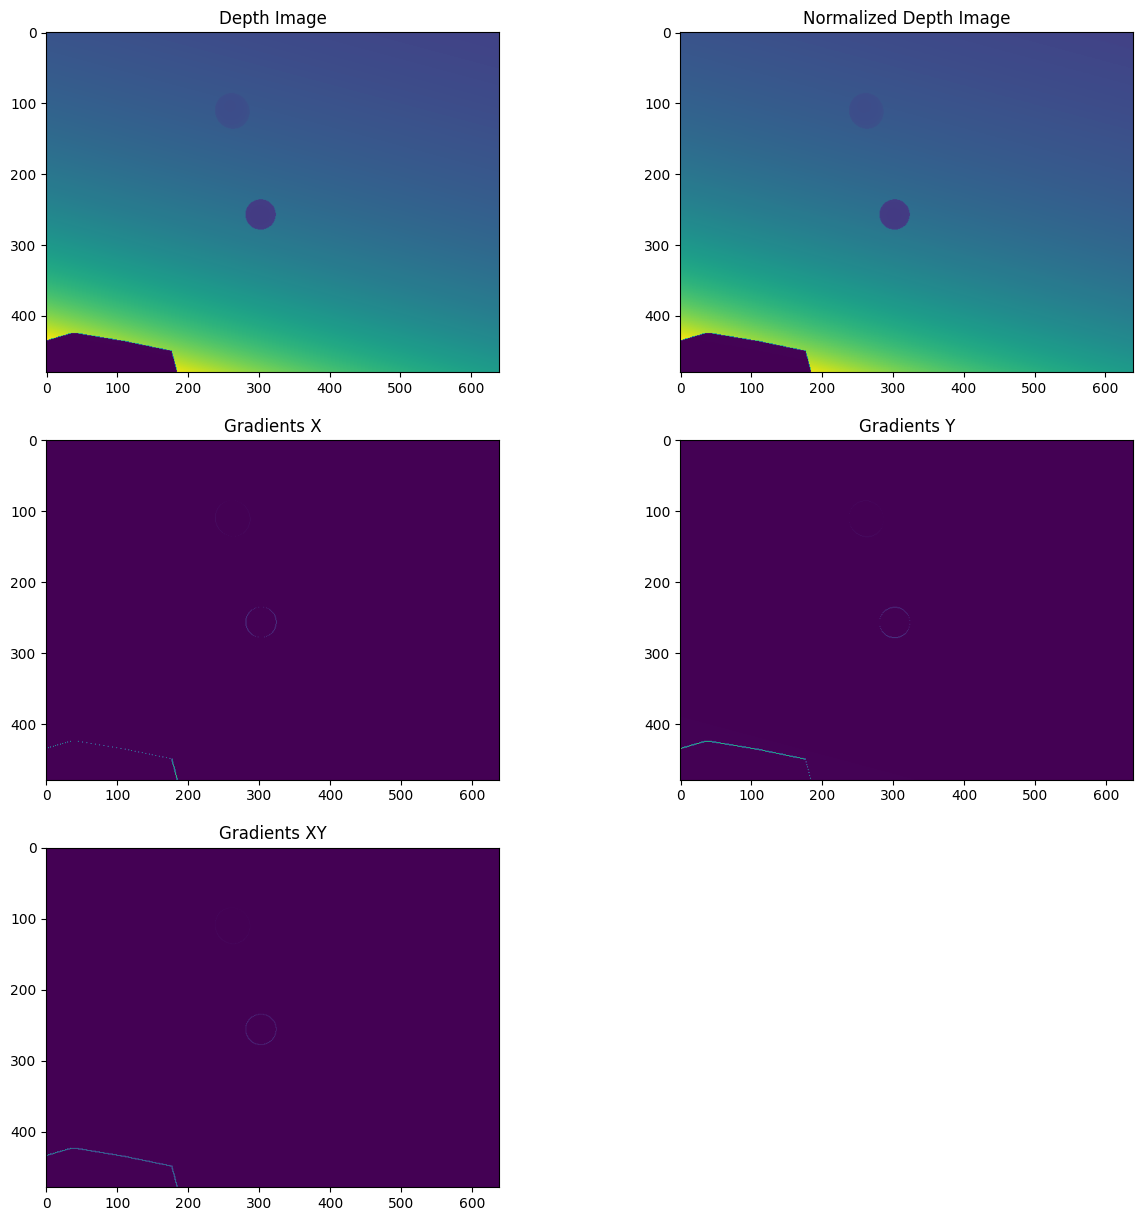

In [176]:
# Load depth image and normalize it
depth_path = Path("input/01396.exr")
depth_im = cv2.imread(str(depth_path), cv2.IMREAD_ANYDEPTH)
# You might want to mask the depth image based on the target object's depth here
norm_depth_im = (255.0 * depth_im / depth_im.max()).astype(np.uint8)

# Compute gradients along X and Y axes
dx = np.abs(depth_im[1:, 1:] - depth_im[1:, :-1])
dy = np.abs(depth_im[1:, 1:] - depth_im[:-1, 1:])
dxy = dx + dy
dxyn = (255 * dxy / dxy.max()).astype(np.uint8)

# Visualize computed images
rows = 3
cols = 2
plt.rcParams["figure.figsize"]=15,15

plt.subplot(rows, cols, 1)
plt.title("Depth Image")
plt.imshow(depth_im.astype('float'))

plt.subplot(rows, cols, 2)
plt.title("Normalized Depth Image")
plt.imshow(norm_depth_im)

plt.subplot(rows, cols, 3)
plt.title("Gradients X")
plt.imshow(dx / dx.max())

plt.subplot(rows, cols, 4)
plt.title("Gradients Y")
plt.imshow(dy / dy.max())

plt.subplot(rows, cols, 5)
plt.title("Gradients XY")
plt.imshow(dxyn)

Computation took 9.04ms


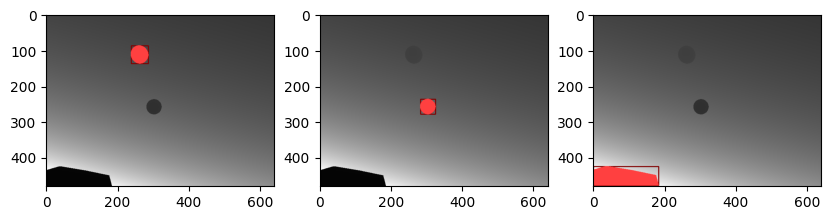

In [168]:
# Compute maximally stable extremal regions in gradient image
start = time.time()
mser = cv2.MSER.create(delta = 1)
msers, bboxes = mser.detectRegions(dxyn)
end = time.time()
print(f"Computation took {1000.0 * (end - start):.2f}ms")

# Visualize detected regions (bounding box and mask)
rows = int(len(msers) / 3 + 1)
plt.rcParams["figure.figsize"]=rows*5,15
for i, bbox in enumerate(bboxes):
    plt.subplot(rows, 3, i+1)
    
    vis_im = np.tile(norm_depth_im.copy()[..., None], (1,1,3))
    cv2.rectangle(vis_im, bbox[:2], bbox[:2] + bbox[2:], [128, 0, 0], 2)
    for pt in msers[i]:
        vis_im = cv2.circle(vis_im, pt, 1, [255, 64, 64]);

    plt.imshow(vis_im)